# Further plan

1. (done) Fix image size, flips, T, beam_center, ...
* (done) Add masks!
* (done) Change structure. q vectors - to detector geometry.
* Fix units! Compare window size, ...
* (done) Optimize cython code and move to a standalone module.
* Write tests (maybe for matlab comparsion as well)
* Make module for visualization

# Compare to matlab results

## Parameters definition

In [1]:
from numpy import pi

k = 1

numberOfImages = 2

nameCounters = [1, 12]

detectorAnglesDelta = [1, 2]
detectorAnglesGamma = [6, 6]
correctSurfaceRefraction = 0;
criticalAngle = 0.14

wavelength = 0.5636
k0 = 2 * pi / wavelength
angleOfIncidence = (k-1)*0.02
sampleTiltAngle = -angleOfIncidence


isRotatedCounterclockwise = 1
isFlippedLeftRight = 0
isFlippedUpDown = 0

detectorDistance = 295

horizontalDetectorSize = 487
verticalDetectorSize = 619
detectorSizeY, detectorSizeZ = verticalDetectorSize, horizontalDetectorSize
numberOfPixels = detectorSizeZ * detectorSizeY

detectorGapsAlongY = []
detectorGapsAlongZ = [[195, 212], [407, 424]]

pixelSizeInMm = 0.172
beamCenterYAtDelta0 = 117
beamCenterZAtGamma0 = 242

outputQResolution = 0.002
outputMaxQXy = 3.5
outputMaxQZ = 2.7

averagingWindow = 1.3 * 2*pi/wavelength * pixelSizeInMm/ detectorDistance

intensityCapBeforeIntRescaling = 100000
hotPixelThreshold = 100000

## Coordinates

### Python implementation

In [39]:
from typing import NamedTuple
import numpy as np


class BeamCenter(NamedTuple):
    z: int
    y: int
        
class Size(NamedTuple):
    z: int
    y: int

def init_coordinates(number_of_pixels: int, size: Size, beam_center: BeamCenter,
                      pixel_size: float, detector_distance: float) -> np.ndarray:
    z_indices = np.arange(size.z - 1, -1, -1)
    y_indices = np.arange(size.y - 1, -1, -1)
    yy, zz = np.meshgrid(y_indices, z_indices)

    z_coordinates = (zz.T.flatten() - beam_center.z) * pixel_size
    y_coordinates = (yy.T.flatten() - beam_center.y) * pixel_size
    x_coordinates = np.ones(number_of_pixels) * detector_distance

    normalization = np.sqrt(x_coordinates ** 2 +
                            y_coordinates ** 2 +
                            z_coordinates ** 2)

    return np.array([x_coordinates,
                     y_coordinates,
                     z_coordinates]) / normalization

### Test

In [42]:
beam_center = BeamCenter(beamCenterZAtGamma0, beamCenterYAtDelta0)
size = Size(detectorSizeZ, detectorSizeY)
coordinates = init_coordinates(numberOfPixels, size, beam_center, pixelSizeInMm, detectorDistance)
coordinates

array([[ 0.95105922,  0.95113044,  0.95120138, ...,  0.9880986 ,
         0.98801974,  0.98794056],
       [ 0.27781246,  0.27783326,  0.27785398, ..., -0.06740507,
        -0.06739969, -0.06739429],
       [ 0.13530188,  0.13475745,  0.1342129 , ..., -0.13826681,
        -0.13883184, -0.13939674]])

## Read image

### Edf reader

In [2]:
import os
import gzip

import numpy as np



def read_edf_from_file(file_path: str):
    data = get_data_from_filepath(file_path)
    return read_edf_from_data(data)


def read_edf_gz(gz_filepath, *, reshape: bool = True):
    _check_file(gz_filepath, '.edf.gz')
    with gzip.open(gz_filepath, 'rb') as f:
        data = f.read()
    return read_edf_from_data(data, reshape=reshape)


def read_edf(edf_filepath, *, reshape: bool = True):
    _check_file(edf_filepath, '.edf')
    with open(edf_filepath, 'rb') as f:
        data = f.read()
    return read_edf_from_data(data, reshape=reshape)


def read_edf_from_data(data, *, reshape: bool = True):
    header_dict = read_header_from_data(data)
    header_end_index = header_dict['headerSize']
    image_size = int(header_dict['Size'])
    raw_image_data = data[header_end_index:header_end_index + image_size]
    data_type = _get_numpy_type(header_dict['DataType'])
    image_shape = (int(header_dict['Dim_2']), int(header_dict['Dim_1']))

    data = np.frombuffer(raw_image_data, data_type)
    if reshape:
        data = np.rot90(np.reshape(data, image_shape))
    return data, header_dict


def read_edf_header(edf_filepath):
    _check_file(edf_filepath, '.edf')
    with open(edf_filepath, 'rb') as f:
        data = f.read()
    return read_header_from_data(data)


def read_edf_header_from_gz(gz_filepath):
    _check_file(gz_filepath, '.edf.gz')
    with gzip.open(gz_filepath, 'rb') as f:
        data = f.read()
    return read_header_from_data(data)


def read_header_from_data(data) -> dict:
    header_end_index = data.find(b'}\n') + 2
    header = data[1:header_end_index].decode('utf-8')
    header_dict = _get_header_dict(header)
    header_dict.update({'headerSize': header_end_index})
    return header_dict


def read_header_from_file(filepath):
    data = get_data_from_filepath(filepath)
    return read_header_from_data(data)


def get_data_from_filepath(filepath: str):
    _check_file(filepath)
    if filepath.endswith('.edf'):
        with open(filepath, 'rb') as f:
            return f.read()
    elif filepath.endswith('.edf.gz'):
        with gzip.open(filepath, 'rb') as f:
            return f.read()
    else:
        raise ValueError('Unknown file type')


def _get_header_dict(header):
    header_dict = {}
    raw_list = header.replace('\n', '').strip(). \
        replace(' ', ''). \
        replace('{', ''). \
        replace('}', ''). \
        split(';')
    for item in raw_list:
        item = item.split('=')
        if len(item) == 2:
            header_dict.update([item])
    return header_dict


def _check_file(filepath: str, end_filter: str = None) -> None:
    if not os.path.isfile(filepath):
        raise FileNotFoundError(f'File {filepath} doesn\'t exist')
    if end_filter and not filepath.endswith(end_filter):
        raise ValueError(f'File {filepath} is not an {end_filter} file')


def _get_numpy_type(edf_type):
    """
    Returns NumPy type based on edf type
    """
    edf_type = edf_type.upper()
    if edf_type == 'SIGNEDBYTE':
        return np.int8  # "b"
    elif edf_type == 'UNSIGNEDBYTE':
        return np.uint8  # "B"
    elif edf_type == 'SIGNEDSHORT':
        return np.int16  # "h"
    elif edf_type == 'UNSIGNEDSHORT':
        return np.uint16  # "H"
    elif edf_type == 'SIGNEDINTEGER':
        return np.int32  # "i"
    elif edf_type == 'UNSIGNEDINTEGER':
        return np.uint32  # "I"
    elif edf_type == 'SIGNEDLONG':
        return np.int32  # "i"
    elif edf_type == 'UNSIGNEDLONG':
        return np.uint32  # "I"
    elif edf_type == 'SIGNED64':
        return np.int64  # "l"
    elif edf_type == 'UNSIGNED64':
        return np.uint64  # "L"
    elif edf_type == 'FLOATVALUE':
        return np.float32  # "f"
    elif edf_type == 'FLOAT':
        return np.float32  # "f"
    elif edf_type == 'DOUBLEVALUE':
        return np.float64  # "d"
    else:
        raise TypeError(f'unknown EdfType {edf_type}')

### Read image

In [3]:
from pathlib import Path

In [4]:
edf_filepaths = list((Path()/'images_for_tests').glob('*.edf'))

In [5]:
len(edf_filepaths)

22

In [6]:
couple_image_list = [(read_edf(str(edf_filepaths[i]))[0], read_edf(str(edf_filepaths[i + 11]))[0])
                    for i in range(len(edf_filepaths) // 2)]

In [7]:
img, _ = read_edf(str(edf_filepaths[0]))

In [8]:
img2, _ = read_edf(str(edf_filepaths[11]))

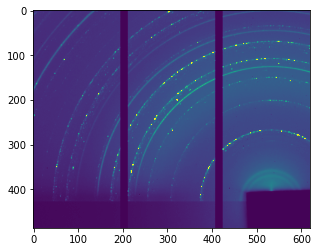

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img, vmax=5000)

## Rotation matrices

In [82]:
def init_rotation_matrix(angle_gamma: float, angle_delta: float,
                          sample_tilt_angle: float) -> np.ndarray:
    gamma_angle = angle_gamma * np.pi / 180
    delta_angle = angle_delta * np.pi / 180
    sample_tilt_angle = sample_tilt_angle * np.pi / 180

    r_matrix_gamma = np.array([[np.cos(gamma_angle), 0, - np.sin(gamma_angle)],
                               [0, 1, 0],
                               [np.sin(gamma_angle), 0, np.cos(gamma_angle)]])
    r_matrix_delta = np.array([[np.cos(delta_angle), - np.sin(delta_angle), 0],
                               [np.sin(delta_angle), np.cos(delta_angle), 0],
                               [0, 0, 1]])
    r_matrix_chi = np.array([[np.cos(sample_tilt_angle), 0, - np.sin(sample_tilt_angle)],
                             [0, 1, 0],
                             [np.sin(sample_tilt_angle), 0, np.cos(sample_tilt_angle)]])

    return r_matrix_delta.dot(r_matrix_gamma).dot(r_matrix_chi)

In [84]:
matrix = init_rotation_matrix(detectorAnglesGamma[0], detectorAnglesDelta[0], sampleTiltAngle)
matrix

array([[ 0.99437042, -0.01745241, -0.10451254],
       [ 0.0173568 ,  0.9998477 , -0.00182427],
       [ 0.10452846,  0.        ,  0.9945219 ]])

In [85]:
rotated_vector = matrix.dot(coordinates)

## Angles

In [146]:
from typing import Tuple


def init_angle_vectors(coordinates: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    vertical_angles = np.arcsin(coordinates[2])
    horizontal_angles = np.sign(coordinates[1]) * np.arccos(
        coordinates[0] / np.sin(np.pi / 2 - vertical_angles)
    )
    return vertical_angles, horizontal_angles

In [91]:
vertical_angles, horizontal_angles = init_angle_vectors(rotated_vector)

In [95]:
vertical_angles[0], vertical_angles[-1]

(0.2361625626252582, -0.035372576252040086)

In [96]:
horizontal_angles[0], horizontal_angles[-1]

(0.3072358476909344, -0.05003440134539258)

In [150]:
horizontal_angles.shape

(301453,)

In [151]:
vertical_angles.shape

(301453,)

## Q vectors

In [125]:
def transform_angles_to_q(vertical_angles: np.ndarray, horizontal_angles: np.ndarray,
                           angle_of_incidence: float,
                           number_of_pixels: int, k0: float) -> Tuple[np.ndarray, np.ndarray]:
    
    angle_of_incidence = angle_of_incidence * np.pi / 180
    xy_sign = np.sign(horizontal_angles)

    q_xy = xy_sign * k0 * np.sqrt(
        (
                np.cos(vertical_angles) * np.cos(horizontal_angles) -
                np.cos(angle_of_incidence)
        ) ** 2 +
        (
                np.cos(
                    vertical_angles) * np.sin(horizontal_angles)
        ) ** 2
    )

    q_z = k0 * (np.sin(vertical_angles) +
                   np.sin(angle_of_incidence))
    return q_xy, q_z

In [126]:
q_xy, q_z = transform_angles_to_q(vertical_angles, horizontal_angles,
                               angleOfIncidence,
                               numberOfPixels, k0)

In [127]:
q_xy

array([ 3.37822348,  3.37812954,  3.378036  , ..., -0.55770603,
       -0.55765788, -0.55760978])

In [128]:
q_z

array([ 2.60840749,  2.6024543 ,  2.59649944, ..., -0.38155017,
       -0.3879067 , -0.39426208])

In [130]:
img.flatten()

array([-40, -40, 614, ...,   3,   3,   4])

## Interpolation

In [131]:
from scipy.interpolate import LinearNDInterpolator

In [173]:
class QMap(NamedTuple):
    qxy_start: float
    qxy_end: float
    qxy_num: int
    qz_start: float
    qz_end: float
    qz_num: int
        
    @classmethod
    def from_step(cls, qxy_end: float, qz_end: float, q_resolution: float):
        qxy_start = 0
        qz_start = 0
        qxy_num = int(qxy_end / q_resolution)
        qz_num = int(qz_end / q_resolution)
        return cls(qxy_start, qxy_end, qxy_num, qz_start, qz_end, qz_num)
    
    @property
    def qxy(self) -> np.ndarray:
        return np.linspace(self.qxy_start, self.qxy_end, self.qxy_num)
    
    @property
    def qz(self) -> np.ndarray:
        return np.linspace(self.qz_start, self.qz_end, self.qz_num)

    @property
    def q_vector(self) -> np.ndarray:
        qxy, qz = np.meshgrid(self.qxy, self.qz)
        return np.swapaxes(np.stack([qxy.flatten(), qz.flatten()]), 0, 1)

    def update(self, **kwargs) -> 'QMap':
        params = self._asdict()
        params.update(kwargs)
        return QMap(**params)

In [174]:
q_map = QMap.from_step(outputMaxQXy, outputMaxQZ, outputQResolution)

In [175]:
q_map.q_vector.shape

(2362500, 2)

In [167]:
coordinate_vector = np.swapaxes(np.stack([q_xy, q_z]), 0, 1)
coordinate_vector.shape

(301453, 2)

In [168]:
img.flatten().shape

(301453,)

In [169]:
interpolator = LinearNDInterpolator(coordinate_vector, img.flatten())

In [176]:
res = interpolator(q_map.q_vector)

In [179]:
converted = res.reshape(q_map.qxy_num, q_map.qz_num)

In [181]:
import matplotlib.pyplot as plt

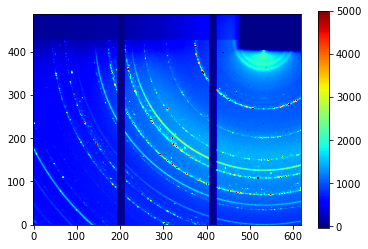

In [186]:
plt.imshow(img, origin=True, cmap='jet', vmax=5000)
plt.colorbar()

# Use package

## Imports

In [33]:
%reload_ext autoreload

In [10]:
%load_ext autoreload

In [11]:
%autoreload 1
%aimport qmap_interpolation

qmap imported.


In [10]:
import qmap_interpolation as qm
from qmap_interpolation import *
from qmap_interpolation import units as uq

qmap imported.


## Fixures

In [11]:
beam_center = BeamCenter(beamCenterZAtGamma0, beamCenterYAtDelta0)
size = Size(detectorSizeZ, detectorSizeY)

In [12]:
instrument = Instrument(wavelength, size, pixelSizeInMm)

In [13]:
mask = np.ones_like(img, dtype=bool)
for x1, x2 in detectorGapsAlongZ:
    mask[:, x1:x2] = False

In [14]:
detector_geometry = DetectorGeometry(instrument, beam_center, angleOfIncidence, 
                                     detectorDistance, sampleTiltAngle, detectorAnglesDelta[0],
                                     detectorAnglesGamma[0], mask)

In [15]:
detector_geometry_2 = DetectorGeometry(instrument, beam_center, angleOfIncidence, 
                                       detectorDistance, sampleTiltAngle, detectorAnglesDelta[1],
                                       detectorAnglesGamma[1], mask)

In [117]:
%%time

converted_images = []

for im1, im2 in couple_image_list:
    c_image = ConvertedImage([Image(im1, detector_geometry), Image(im2, detector_geometry_2)])
    q_xy, q_z, images = c_image.get_vectors()
    window_size = c_image.default_window()
    converted = boxInterpolation(images, q_xy, q_z,
                                   q_map.qxy_num, q_map.qz_num, 
                                   q_map.qxy_start, q_map.qxy_step, 10 * window_size,
                                   q_map.qz_start, q_map.qz_step, 10 * window_size)
    converted_images.append(converted)

Wall time: 3.44 s


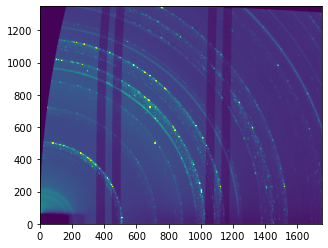

In [119]:
plt.imshow(converted_images[1], origin=True, vmax=5000)

In [18]:
q_image = Image(img, detector_geometry)

q_image_2 = Image(img2, detector_geometry_2)

c_image = ConvertedImage([q_image, q_image_2])

q_map = QMap(0,outputMaxQXy, int(outputMaxQXy / outputQResolution),
             0, outputMaxQZ, int(outputMaxQZ / outputQResolution))

q_xy, q_z, images = c_image.get_vectors()

# Cython

In [19]:
import cython

%load_ext Cython

### Pure numpy implementation

In [102]:
from numpy import floor, ceil

import numpy as np

def py_getind(xmsdel: float, hwdel: float, n: int):
    imin = int(ceil(xmsdel - hwdel))
    if (imin < 0):
        imin = 0
    if (imin > (n - 1)):
        imin = n
    imax = int(floor(xmsdel + hwdel))
    if (imax < 0):
        imax = -1
    if (imax > (n - 1)):
        imax = n - 1
    return imin, imax


def pyBoxInterpolation(inten: np.ndarray, qx: np.ndarray, qy: np.ndarray,
         ndat: int, nx: int, ny: int, 
         xs: float,  xdel: float,  xhw: float,
         ys: float,  ydel: float,  yhw: float):
    size = nx * ny
    ninten = np.zeros(size)
    ginten = np.zeros(size)

    xhwdel = xhw / 2. / xdel
    yhwdel = yhw / 2./ ydel

    for i in range(ndat):
        xmsdel = (qx[i] - xs) / xdel
        ximin, ximax = py_getind(xmsdel, xhwdel, nx)
        xmsdel = (qy[i] - ys) / ydel
        yimin, yimax = py_getind(xmsdel, yhwdel, ny)

        for l in range(ximin, ximax + 1):
            ninten[l * ny + yimin: l * ny + yimax + 1] += 1
            ginten[l * ny + yimin: l * ny + yimax + 1] += inten[i]
            
    return np.nan_to_num(ginten / ninten)

### Cython implementation with numpy usage

In [20]:
%%cython -a

from libc.math cimport floor, ceil

import numpy as np
cimport numpy as np
cimport cython


cdef inline (int, int) getind(double xmsdel, double hwdel, int n):
    cdef int imin = int(ceil(xmsdel - hwdel))
    if (imin < 0):
        imin = 0
    elif (imin > (n - 1)):
        imin = n
    cdef int imax = int(floor(xmsdel + hwdel))
    if (imax < 0):
        imax = -1
    elif (imax > (n - 1)):
        imax = n - 1
    return imin, imax


@cython.boundscheck(False)
@cython.wraparound(False)
def boxInterpolation(
        np.ndarray[np.float_t, ndim=1] inten, 
        np.ndarray[np.float_t, ndim=1] qx, 
        np.ndarray[np.float_t, ndim=1] qy,
        int nx, int ny, 
        double xs, double xdel, double xhw,
        double ys, double ydel, double yhw):
    
    cdef int ximin, ximax, yimin, yimax
    cdef int i, k, l, ind
    cdef int size = nx * ny
    cdef double xmsdel
    
    cdef np.ndarray[np.float_t, ndim=1] ninten = np.zeros(size)
    cdef np.ndarray[np.float_t, ndim=1] ginten = np.zeros(size)

    cdef double xhwdel = xhw / 2. / xdel
    cdef double yhwdel = yhw / 2./ ydel

    for i in range(inten.size):
        xmsdel = (qx[i] - xs) / xdel
        ximin, ximax = getind(xmsdel, xhwdel, nx)
        xmsdel = (qy[i] - ys) / ydel
        yimin, yimax = getind(xmsdel, yhwdel, ny)

        for l in range(ximin, ximax + 1):
            for k in range(yimin, yimax + 1):
                ind = k * nx + l
                ninten[ind] += 1
                ginten[ind] += inten[i]

    for i in range(size):
        if ninten[i] != 0:
            ginten[i] = ginten[i] / ninten[i]
    return ginten.reshape((ny, nx)) 

### Cython with multithreading

In [96]:
%%cython --force

from libc.math cimport floor, ceil

import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange


cdef inline (int, int) getind(double xmsdel, double hwdel, int n) nogil:
    cdef int imin = int(ceil(xmsdel - hwdel))
    if (imin < 0):
        imin = 0
    elif (imin > (n - 1)):
        imin = n
    cdef int imax = int(floor(xmsdel + hwdel))
    if (imax < 0):
        imax = -1
    elif (imax > (n - 1)):
        imax = n - 1
    return imin, imax


@cython.boundscheck(False)
@cython.wraparound(False)
def boxInterpolationP(
        np.ndarray[np.float_t, ndim=1] inten, 
        np.ndarray[np.float_t, ndim=1] qx, 
        np.ndarray[np.float_t, ndim=1] qy,
        int ndat, int nx, int ny, 
        double xs, double xdel, double xhw,
        double ys, double ydel, double yhw):
    
    cdef int ximin, ximax, yimin, yimax
    cdef int i, k, l, ind
    cdef int size = nx * ny
    cdef double xmsdel
    
    cdef np.ndarray[np.float_t, ndim=1] ninten = np.zeros(size)
    cdef np.ndarray[np.float_t, ndim=1] ginten = np.zeros(size)

    cdef double xhwdel = xhw / 2. / xdel
    cdef double yhwdel = yhw / 2./ ydel

    for i in prange(ndat, nogil=True):
        xmsdel = (qx[i] - xs) / xdel
        ximin, ximax = getind(xmsdel, xhwdel, nx)
        xmsdel = (qy[i] - ys) / ydel
        yimin, yimax = getind(xmsdel, yhwdel, ny)

        for l in range(ximin, ximax + 1):
            for k in range(yimin, yimax + 1):
                ind = k * nx + l
                ninten[ind] += 1
                ginten[ind] += inten[i]
    for i in prange(size, nogil=True):
        if ninten[i] != 0:
            ginten[i] = ginten[i] / ninten[i]
    return ginten

### Interpolation

In [20]:
q_xy, q_z, images = c_image.get_vectors()

NameError: name 'c_image' is not defined

In [21]:
window_size = c_image.default_window()

NameError: name 'c_image' is not defined

In [22]:
detector_geometry

DetectorGeometry(instrument=Instrument(wavelength=0.5636, size=Size(z=487, y=619), pixel_size=0.172, hot_pixel_threshold=None), beam_center=BeamCenter(z=242, y=117), angle_of_incidence=0.0, detector_distance=295, sample_tilt_angle=-0.0, angle_delta=1, angle_gamma=6, mask=None)

In [104]:
%%time

for i in range(10):
    res = boxInterpolation(images, q_xy, q_z,
                           q_map.qxy_num, q_map.qz_num, 
                           q_map.qxy_start, q_map.qxy_step, 10 * window_size,
                           q_map.qz_start, q_map.qz_step, 10 * window_size)

Wall time: 1.12 s


In [107]:
%%time

for i in range(10):
    res = boxInterpolationP(images, q_xy, q_z, images.size,
                           q_map.qxy_num, q_map.qz_num, 
                           q_map.qxy_start, q_map.qxy_step, 15 * window_size,
                           q_map.qz_start, q_map.qz_step, 15 * window_size)

Wall time: 1.29 s


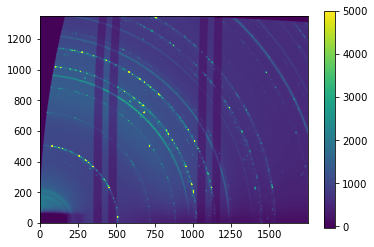

In [112]:
import matplotlib.pyplot as plt

res = boxInterpolation(images, q_xy, q_z,
                       q_map.qxy_num, q_map.qz_num, 
                       q_map.qxy_start, q_map.qxy_step, 10 * window_size,
                       q_map.qz_start, q_map.qz_step, 10 * window_size)

plt.imshow(res, vmax=5000, origin=True)
plt.colorbar()

# Analysis

In [16]:
couple_image_list = [(read_edf(str(edf_filepaths[i]))[0], read_edf(str(edf_filepaths[i + 11]))[0])
                    for i in range(len(edf_filepaths) // 2)]

In [20]:
%%time

converted_images = []

c_image = ConvertedImage()
q_map = QMap(0,outputMaxQXy, int(outputMaxQXy / outputQResolution),
             0, outputMaxQZ, int(outputMaxQZ / outputQResolution))

for im1, im2 in couple_image_list:
    im1 = np.flip(np.flip(im1, axis=0), axis=1)
    im2 = np.flip(np.flip(im2, axis=0), axis=1)
    c_image.clear()
    c_image.append_image(Image(im1, detector_geometry))
    c_image.append_image(Image(im2, detector_geometry_2))
    converted = c_image.calculate_converted_image(q_map)
    converted_images.append(converted)

Wall time: 838 ms


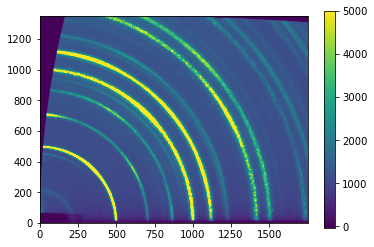

In [28]:
import matplotlib.pyplot as plt

plt.imshow(converted_images[9], origin=True, vmax=5000)
plt.colorbar()